In [1]:
import os
import ahpy
import json
import math
import random
import hashlib
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt

from utils import Infiltrometro, ALL_FUNCTIONS, nse, points_distance, USO_SOLO_CLASS, SOIL_TYPES

from tqdm import tqdm
from xgboost import XGBRegressor
from shapely.geometry import Point
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from itertools import combinations, product, islice
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import QuantileTransformer

In [2]:
OBS = rxr.open_rasterio(r"D:\Mestrado\Trabalho Final\SIG\ClassificacaoCondutividadeHidraulica.tif") # Raster com dados classificados pela condutividade
AHP = rxr.open_rasterio(r"D:\Mestrado\Trabalho Final\SIG\Classificacao_Infiltracao_AHP_2.tif")      # Raster com dados classificados pelo método AHP
MIF = rxr.open_rasterio(r"D:\Mestrado\Trabalho Final\SIG\Classificacao_Infiltracao_MIF_2.tif")      # Raster com dados classificados pelo método MIF
AD  = gpd.read_file(r"D:\Mestrado\Trabalho Final\SIG\AreaDrenagemIbirite.zip")                      # Shape com a área toda

In [3]:
layers = ["AD", "Urubu", "Taboão", "Sumidouro", "Rola Moça", "Pintado", "Jatobá", "Fubá", "Barreirinho"]

rasters = {
    "OBS": OBS,
    "AHP": AHP,
    "MIF": MIF,
}

for key in [i for i in ALL_FUNCTIONS.keys()] + ['XGB', 'RF']:
    rasters[key] = rxr.open_rasterio(fr"D:\Mestrado\Trabalho Final\SIG\Classificacao_Infiltracao_{key}.tif")

In [4]:
types = ["OBS", "AHP", "MIF"] + [i for i in ALL_FUNCTIONS.keys()] + ['XGB', 'RF']

data = {
    "geometry": [],
}

for key in types:
    data[key] = []

for layer in layers:
    if layer == "AD":
        gdf = AD
    else:
        gdf = gpd.read_file(r"D:\Mestrado\Trabalho Final\SIG\subbacias2.gpkg", layer = layer)
    
    gdf_geom = gdf.to_crs("EPSG:31983").copy()
    geom = gdf_geom.geometry.values.union_all()
    data["geometry"].append(geom)
    
    for name, rast in tqdm(rasters.items(), desc=f"{layer} - Raster", total=len(rasters)):

        # Clipando o raster:
        clipped = rast.rio.clip([geom], drop=True)

        arr = clipped.squeeze().values
        arr = arr[(~np.isnan(arr)) & (arr >= 0)]

        mean   = np.mean(arr)
        median = np.median(arr)
        min    = np.min(arr)
        max    = np.max(arr)

        data[name].append({
            "subbacia": layer,
            "mean": mean,
            "median":median,
            "min": min,
            "max": max,
        })

# for tipo in tqdm(types, desc="Salvando", total=len(types)):
#     gdf = gpd.GeoDataFrame(data[tipo], geometry=data["geometry"], crs="EPSG:31983")
#     gdf.to_file(r"D:\Mestrado\Trabalho Final\SIG\subbacias.gpkg", layer = tipo)

Barreirinho - Raster: 100%|██████████| 13/13 [00:14<00:00,  1.13s/it]


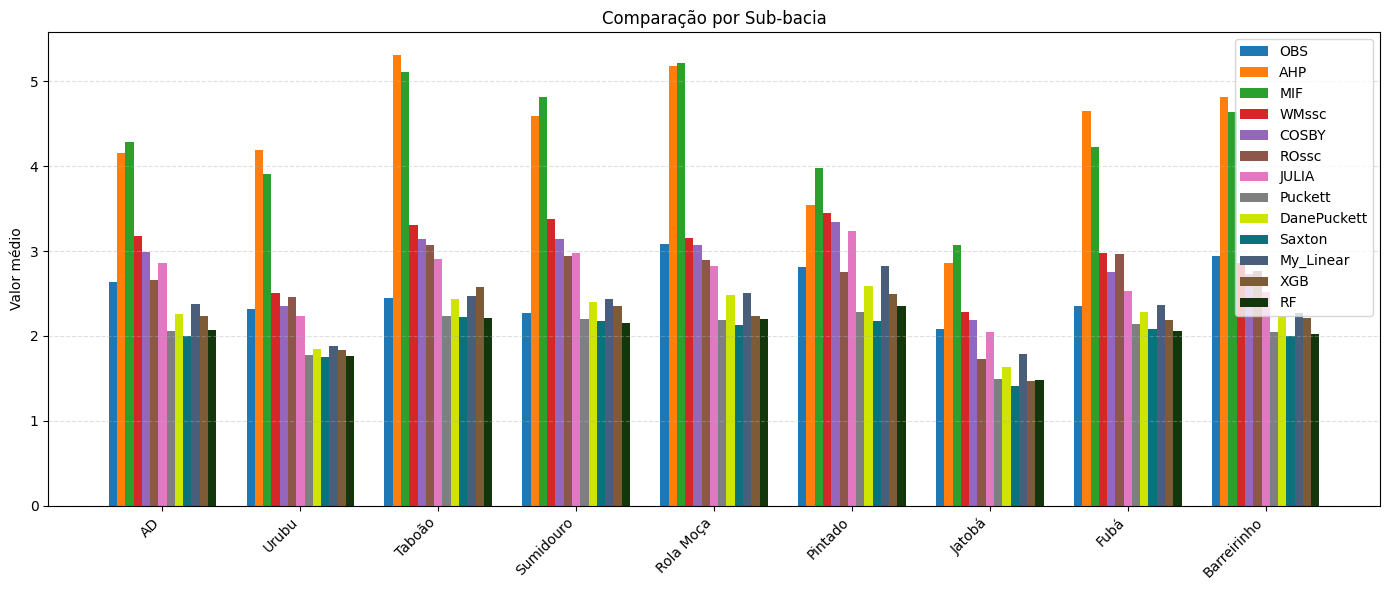

In [53]:
# Converter seu dicionário em DataFrame
# df = pd.DataFrame(data)
# df = df.reindex(layers)

# Número de grupos (sub-bacias)
n = len(layers)

# Número de categorias (OBS, AHP, MIF)
k = len(types)

# Largura de cada barra
width = 0.06

# Posições no eixo X
x = np.arange(n)

# Cores
colors = [
    "#1f77b4ff",  # azul
    "#ff7f0eff",  # laranja
    "#2ca02cff",  # verde
    "#d62728ff",  # vermelho
    "#9467bdff",  # roxo
    "#8c564bff",  # marrom
    "#e377c2ff",  # rosa
    "#7f7f7fff",  # cinza
    "#cde405ff",  # oliva
    "#0b717cff",  # ciano
    "#485e7aff",  # azul claro
    "#7e5b37ff",  # laranja claro
    "#13360cff"   # verde claro
]

# Criar gráfico
plt.figure(figsize=(14, 6))

# Plotar cada coluna deslocada no eixo X
for i, type in enumerate(types):
    values = []
    for layer in layers:
        dados = data[type]
        values.append(data[type][layers.index(layer)]["mean"])

    plt.bar(x - ((width*(k-1))/2) + (i*width), values, width, label=type, color=colors[i])

# plt.bar(x - width, df["OBS"], width, label="OBS", color="#1f77b4")
# plt.bar(x,         df["AHP"], width, label="AHP", color="#ff7f0e")
# plt.bar(x + width, df["MIF"], width, label="MIF", color="#2ca02c")

# Ajustes visuais
plt.xticks(x, layers, rotation=45, ha="right")
plt.ylabel("Valor médio")
plt.title("Comparação por Sub-bacia")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()


In [59]:
# Comparações com o observado

erros_type = {}
for i, type in enumerate(types):
    if type == "OBS":
        continue
    
    sum_erro = 0
    print(f"Para o método {type}:")
    for layer in layers:
        dados = data[type]
        value = data[type][layers.index(layer)]["mean"]
        value_obs = data['OBS'][layers.index(layer)]["mean"]

        erro = value_obs - value
        sum_erro += erro
        print(f"\tLayer {layer}: {erro}")
    print(f"\tCom média de {sum_erro/len(layers)}")

Para o método AHP:
	Layer AD: -1.520993709564209
	Layer Urubu: -1.884392261505127
	Layer Taboão: -2.868006467819214
	Layer Sumidouro: -2.3260414600372314
	Layer Rola Moça: -2.0990402698516846
	Layer Pintado: -0.7368743419647217
	Layer Jatobá: -0.7819197177886963
	Layer Fubá: -2.299344778060913
	Layer Barreirinho: -1.8684430122375488
	Com média de -1.8205617666244507
Para o método MIF:
	Layer AD: -1.644927978515625
	Layer Urubu: -1.6015293598175049
	Layer Taboão: -2.663724184036255
	Layer Sumidouro: -2.5500247478485107
	Layer Rola Moça: -2.1238181591033936
	Layer Pintado: -1.1708786487579346
	Layer Jatobá: -0.9854307174682617
	Layer Fubá: -1.8766014575958252
	Layer Barreirinho: -1.6949739456176758
	Com média de -1.8124343156814575
Para o método WMssc:
	Layer AD: -0.5372653007507324
	Layer Urubu: -0.19380950927734375
	Layer Taboão: -0.8657143115997314
	Layer Sumidouro: -1.1056876182556152
	Layer Rola Moça: -0.07000231742858887
	Layer Pintado: -0.6354146003723145
	Layer Jatobá: -0.1968996